# Prueba de hipótesis

En los conjuntos de datos que hemos explorado, hemos visto diferencias entre grupos de personas (y pingüinos).
Resultados como estos se denominan **efectos observados** porque aparecen en una muestra, en contraste con los efectos reales en la población, que normalmente no podemos observar directamente.
Cuando vemos un efecto aparente, debemos considerar si es probable que esté presente en la población más amplia o si podría aparecer en la muestra por casualidad.

Hay varias formas de formular esta pregunta. Lo que presento aquí es una mezcla de diferentes aproximaciones y metodologias que se utiliza a menudo en la práctica.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def from_seq(seq, name=None, normalize=True, sort=True, ascending=True, dropna=True, na_position="last", convert_to="PMF"):
  """Crea un PMF a partir de una secuencia de valores.
  Args:
      seq: iterable
      normalize: si se debe normalizar la serie (i.e, Pmf), por defecto True
      sort: si se debe ordenar la serie por valores, por defecto True
      ascending: si se debe ordenar en orden ascendente, por defecto True
      dropna: si se deben eliminar los valores NaN, por defecto True
      na_position: si es 'first', coloca los NaNs al principio;
                  si es 'last', coloca los NaNs al final.
      convert_to: si es 'FreqTab', Crea una tabla de frecuencia;
                  si es 'PMF' (default), crea una funcion de masa de probabilidad;
                  si es 'CDF', crea una función de distribución acumulada.

  Returns: pd.Series
  """
  if convert_to == "FreqTab":
    normalize=False

  # compute the value counts
  series = pd.Series(seq, name=name).value_counts(normalize=normalize, sort=sort, dropna=dropna)

  # sort in place, if desired
  if sort:
    series.sort_index(inplace=True, ascending=ascending, na_position=na_position)

  if convert_to == "CDF":
    series = np.cumsum(series)

  return series

def get_qs(Tab):
    """Obtener las cantidades.

    Returns: NumPy array
    """
    return Tab.index.values

def get_ps(Tab):
    """Obtener las probabilidades.

    Returns: NumPy array
    """
    return Tab.values

def plot_bar(Tab, xlabel="x", ylabel="y", title=None):
    """Crea un gráfico de barras.

    Args:
        kwargs: se pasa a plt.bar
    """
    qs = get_qs(Tab)
    ps = get_ps(Tab)

    plt.bar(qs, ps)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title is not None:
      plt.title(title)

## Lanzar monedas

Comenzaremos con un ejemplo sencillo,

Supongamos que hacemos girar una moneda sobre su canto 250 veces y observamos que caía con la cara hacia arriba 140 veces y con la cruz hacia arriba 110 veces.

Si la moneda está perfectamente equilibrada, esperamos solo 125 caras, por lo que estos datos sugieren que la moneda está sesgada.
Por otro lado, no esperamos obtener exactamente 125 caras cada vez, por lo que es posible que la moneda sea realmente imparcial y que la aparente desviación del **valor esperado** se deba al azar.
Para ver si eso es plausible, podemos realizar una **prueba de hipótesis**.

$$
error = |\hat{x}-x|
$$

Usaremos la siguiente función para calcular la **diferencia absoluta** entre el número observado y el número esperado si la moneda es imparcial.

In [3]:
np.random.seed(1)

In [4]:
n = 250
p = 0.5

def abs_deviation(heads):
    expected = n * p
    return np.abs(heads - expected)

En los datos observados, esta desviación es de **15**.

In [5]:
heads = 140
tails = 110

observed_stat = abs_deviation(heads)
observed_stat.item()

15.0

Si la moneda es realmente imparcial, podemos simular el experimento de lanzar la moneda generando una secuencia de cadenas aleatorias, ya sea "C" o "X" con la misma probabilidad, y contando el número de veces que aparece "C".

In [6]:
def simulate_flips():
    flips = np.random.choice(["C", "X"], size=n)
    heads = np.sum(flips == "C")
    return heads

Cada vez que llamamos esta funcion, obtenemos el resultado de un experimento simulado.

In [7]:
simulate_flips().item()

119

El siguiente bucle simula el experimento muchas veces, calcula la **desviación** para cada uno, sobre el mismo numero de lanzamientos **n**, y utiliza una comprensión de lista para recopilar los resultados en una lista.

In [8]:
simulated_stats = [abs_deviation(simulate_flips()) for i in range(10001)]

El resultado es una muestra de la **distribución de las desviaciones** bajo el supuesto de que la moneda es imparcial.

Así es como se ve la distribución de estos valores.

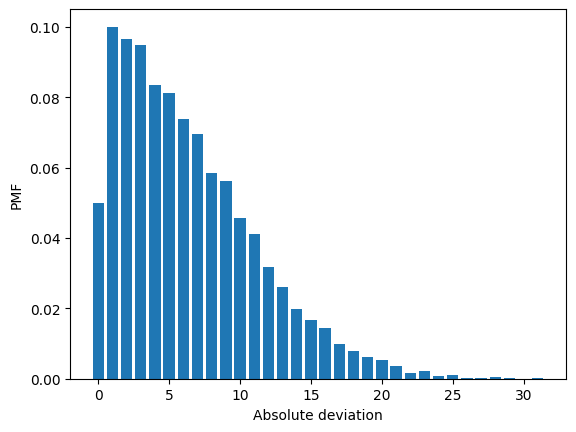

In [9]:
pmf_effects = from_seq(simulated_stats, convert_to="PMF")

plot_bar(pmf_effects, xlabel="Absolute deviation", ylabel="PMF")

Los valores cercanos a **0** son los más comunes; los valores superiores a 10 son menos comunes.

Teniendo en cuenta que la **desviación en los datos observados** es de **15**, vemos que las desviaciones de esa magnitud son poco frecuentes, pero no imposibles.

En este ejemplo, los resultados simulados igualan o superan los **15** aproximadamente el **7.1%** de las veces.

In [10]:
(np.array(simulated_stats) >= 15).mean() * 100

np.float64(7.079292070792921)

En esta linea de codigo, la seccion `np.array(simulated_stats) >= 15` crea un arreglo de booleanos, valor **False** (0) para los elementos `<15` y **True** (1) para los valores `>= 15`.

Por lo tanto, si la moneda es imparcial, esperamos una desviación tan grande como la que vimos aproximadamente el **7.1%** de las veces, solo por casualidad.

Podemos concluir que un efecto de esta magnitud no es común, pero ciertamente no es imposible, incluso si la moneda es imparcial.
Sobre la base de este experimento, no podemos descartar la posibilidad de que la moneda sea imparcial.

Este ejemplo demuestra la lógica de la prueba de hipótesis estadísticas.

1. **Partimos de una observación**. En este ejemplo, la hipótesis de que la moneda está sesgada.

2. Elegimos una **estadística de prueba** que cuantifica la magnitud del efecto observado. En este ejemplo, la estadística de prueba es la *desviación absoluta* del resultado esperado.

3. Definimos una **hipótesis nula**, que es un modelo basado en la suposición de que el efecto observado se debe al azar. En este ejemplo, la hipótesis nula es que la moneda es imparcial.

4. A continuación, calculamos un **p-value**, que es la probabilidad de observar el efecto observado si la hipótesis nula es cierta. En este ejemplo, el p-value es la probabilidad de una desviación tan grande como 15 o mayor.

5. Interpretar el resultado.
* Si el p-value es pequeño, concluimos que es poco probable que el efecto se deba al azar.
* Si es grande, concluimos que el efecto podría explicarse de forma plausible por el azar.

En este ejemplo, la probabilidad de observar el resultado obtenido si la moneda es imparcial se encuentra en un punto intermedio, podemos decir que es poco probable que el efecto se deba al azar, pero no podemos descartar la posibilidad.

Todas las pruebas de hipótesis se basan en estos elementos: una estadística de prueba, una hipótesis nula y un p-value.


## Prueba de proporciones

consideremos otro caso en el que la elección de la estadística de prueba requiere cierta reflexión.

Supongamos que usted dirige un casino y sospecha que un cliente está utilizando un **dado trucado**, es decir, uno que ha sido modificado para que una de las caras tenga más probabilidades que las demás.

Detienes al presunto tramposo y le confiscas el dado, pero ahora tienes que demostrar que está trucado.

Tiras el dado **60 veces** y registras la frecuencia de cada resultado del 1 al 6.
Estos son los resultados en un objeto `Series` de `pandas`.

In [11]:
qs = np.arange(1, 7)
freqs = [8, 9, 19, 5, 8, 11]

observed = pd.Series(data=freqs, index=qs)
observed.index.name = "outcome"
observed

outcome
1     8
2     9
3    19
4     5
5     8
6    11
dtype: int64

En promedio, se espera que cada valor aparezca 10 veces.
En este conjunto de datos, el valor 3 aparece con más frecuencia de lo esperado, y el valor 4 aparece con menos frecuencia.
Pero, **¿podrían estas diferencias ser fruto de la casualidad?**

Para comprobar esta hipótesis, comenzaremos calculando la frecuencia esperada para cada resultado.

In [12]:
num_rolls = observed.sum()
outcomes = get_qs(observed)
expected = pd.Series(num_rolls / 6, outcomes)
expected

1    10.0
2    10.0
3    10.0
4    10.0
5    10.0
6    10.0
dtype: float64

La siguiente función toma las **frecuencias observadas** y **esperadas** y calcula la suma de las **diferencias absolutas**.

$$
diff\_abs = \sum_i^n |\hat{x}_i-x_i|
$$

In [13]:
def total_abs_deviation(observed):
    return np.sum(np.abs(observed - expected))

En el conjunto de datos observados, esta estadística de prueba es 20.

In [14]:
observed_dev = total_abs_deviation(observed)
observed_dev.item()

20.0

La siguiente función toma los **datos observados**, simula lanzar un dado imparcial el mismo número de veces y devuelve un Tabla de frecuencia `FreqTab` que contiene las frecuencias simuladas.

In [15]:
def simulate_dice(observed):
    num_rolls = np.sum(observed)
    rolls = np.random.choice( get_qs(observed), num_rolls, replace=True)
    hist = from_seq(rolls, convert_to="FreqTab")
    return hist

El siguiente bucle simula el experimento muchas veces y calcula la desviación absoluta total para cada uno.

In [16]:
simulated_devs = [total_abs_deviation(simulate_dice(observed)) for i in range(1001)]

Así es como se ve la **distribución** de la **estadística de prueba** bajo la **hipótesis nula**.

Observe que el **valor total siempre es par**, porque cada vez que un resultado aparece con más frecuencia de la esperada, otro resultado tiene que aparecer con menos frecuencia.

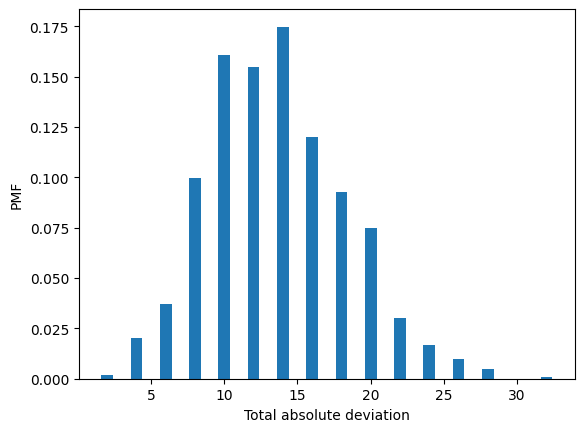

In [17]:
pmf_devs = from_seq(simulated_devs, convert_to="PMF")

plot_bar(pmf_devs, xlabel="Total absolute deviation", ylabel="PMF")

Podemos ver que una desviación total de 20 no es inusual: el **p-value** es de aproximadamente el `13%`, lo que significa que no podemos estar seguros de que el dado esté trucado.

In [18]:
def compute_p_value(simulated, observed):
    """Fracción de valores simulados iguales o mayores que el valor observado."""
    return (np.asarray(simulated) >= observed).mean().item()

In [19]:
compute_p_value(simulated_devs, observed_dev)

0.13786213786213786

Alternativamente podemos calcularlo de la siguiente manera:

In [20]:
(pmf_devs[pmf_devs.index >= 20]).sum().item() * 100

13.786213786213786

Pero la estadística de prueba que elegimos no era la única opción.

<br>

---



Para un problema como este, sería más convencional utilizar la **estadística chi-cuadrado**, que podemos calcular así.

$$
X^2 = \sum_i^n \frac{(O_i-E_i)^2}{E_i}
$$
donde
* $X^2$ chi-cuadrado
* $O_i$ Valor observado
* $E_i$ Valor esperado

In [21]:
def chi_squared_stat(observed):
    diffs = (observed - expected) ** 2
    return np.sum(diffs / expected)

Al elevar al cuadrado las desviaciones (en lugar de tomar los valores absolutos) se da más peso a las **desviaciones grandes**.

Al dividir por `expected` se **estandarizan las desviaciones**, aunque en este caso no tiene ningún efecto en los resultados porque las frecuencias esperadas son todas iguales.

In [22]:
observed_chi2 = chi_squared_stat(observed)
observed_chi2.item()

11.6

La **estadística chi-cuadrado** de los datos observados es `11.6`.
Por sí sola, esta cifra no significa gran cosa, pero podemos compararla con los resultados de los lanzamientos simulados.

El siguiente bucle genera muchos conjuntos de datos simulados y calcula la estadística chi-cuadrado para cada uno de ellos.

In [23]:
from scipy.stats import gaussian_kde

def make_pmf(sample, low, high):
    kde = gaussian_kde(sample)
    qs = np.linspace(low, high, 201)
    ps = kde(qs)
    return pd.Series(data=ps, index=qs)

In [24]:
def fill_tail(pmf, observed, side):
    """Fill the area under a PMF, right or left of an observed value."""
    if side == "right":
        condition = get_qs(pmf) >= observed
    elif side == "left":
        condition = get_qs(pmf) <= observed

    series = pmf[condition]
    plt.fill_between(series.index, 0, series, alpha=0.3)

In [25]:
simulated_chi2 = [chi_squared_stat(simulate_dice(observed)) for i in range(1001)]

Así es como se ve la distribución de esta estadística de prueba bajo la hipótesis nula.

La **región sombreada** muestra los resultados que superan el valor observado.

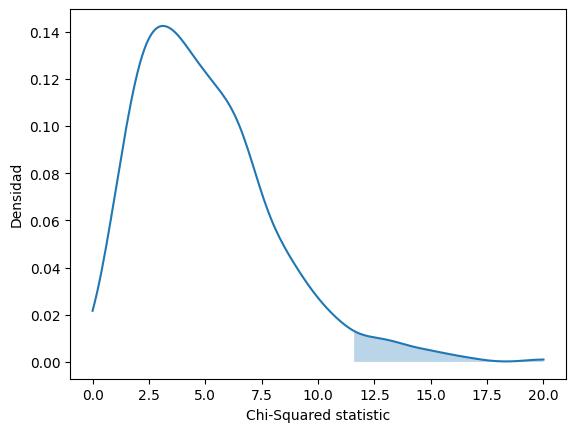

In [26]:
pmf = make_pmf(simulated_chi2, 0, 20)
pmf.plot()
fill_tail(pmf, observed_chi2, "right")

plt.xlabel("Chi-Squared statistic")
plt.ylabel("Densidad")
plt.show()

Una vez más, el área de la región sombreada es el **p-value**.

In [27]:
compute_p_value(simulated_chi2, observed_chi2)

0.03696303696303696

El **p-value** utilizando la estadística chi-cuadrado es de aproximadamente `0.04`, sustancialmente menor que el que obtuvimos utilizando la desviación total, `0.13`.

En este experimento, si tomamos en serio el umbral del `5%`, consideraríamos este efecto estadísticamente significativo. Ya que si **p-value** $≤ \alpha$, rechaza la $H_0$.

Pero teniendo en cuenta las dos pruebas juntas, podriamos decir que los resultados no son concluyentes.
No descartaría la posibilidad de que el dado esté trucado, pero no condenaría al acusado de hacer trampa.

* Este ejemplo ilustra un punto importante: el **p-value** depende de la elección de la **estadística de prueba** y del **modelo de la hipótesis nula**, y a veces estas elecciones determinan si un efecto es estadísticamente significativo o no.

## Prueba de la diferencia en las medias

En los datos de la NSFG, observamos que la duración media del embarazo para los primeros bebés es ligeramente superior a la de los demás bebés.
Ahora veamos si esa diferencia podría deberse al azar.

In [28]:
try:
    import statadict
except ImportError:
    %pip install statadict

from statadict import parse_stata_dict
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

In [29]:
def clean_fem_preg(df):
    """Recodifica las variables de la tabla de embarazo.
    Args:
        df: DataFrame de datos de embarazo que se van a limpiar.

    Modifies:
        agepreg: edad (dato float) de la madre al final del embarazo
        birthwgt_lb: peso (dato float) al nacer en libras
        birthwgt_oz: peso al nacer en onzas (dato float)
        totalwgt_lb: peso total al nacer en libras (dato float)
        hpagelb: peso de la madre en el último periodo menstrual (dato float)
        babysex: sexo del bebé (dato int) (1 = varón, 2 = mujer)
        nbrnaliv: número de bebés nacidos vivos (dato int)
    """
    df.agepreg /= 100.0
    df.loc[df.birthwgt_lb > 20, "birthwgt_lb"] = np.nan
    na_vals = [97, 98, 99]
    df["birthwgt_lb"] = df.birthwgt_lb.replace(na_vals, np.nan)
    df["birthwgt_oz"] = df.birthwgt_oz.replace(na_vals, np.nan)
    df["totalwgt_lb"] = df.birthwgt_lb + df.birthwgt_oz / 16.0

    df["hpagelb"] = df.hpagelb.replace(na_vals, np.nan)
    df["babysex"] = df.babysex.replace([7, 9], np.nan)
    df["nbrnaliv"] = df.nbrnaliv.replace([9], np.nan)

def read_fem_preg(dct_file="2002FemPreg.dct", dat_file="2002FemPreg.dat.gz"):
    """Lee los datos sobre embarazos de la NSFG.
    Args:
        dct_file: nombre del archivo de diccionario en forma de string.
        dat_file: nombre del archivo de datos en forma de string.

    Returns:
        DataFrame: datos sobre embarazos de la NSFG con variables limpias.
    """
    stata_dict = parse_stata_dict(dct_file)

    preg = pd.read_fwf(
        dat_file,
        names=stata_dict.names,
        colspecs=stata_dict.colspecs,
        compression= 'gzip',)

    clean_fem_preg(preg)
    return preg

def get_nsfg_groups():
    """Lee el archivo de embarazos NSFG y lo divide en grupos.
    Returns:
        tuple: (live, firsts, others) donde:
            live: DataFrame de todos los nacidos vivos
            firsts: DataFrame de los primeros bebés
            others: DataFrame de los demás bebés
    """
    live = read_fem_preg().query("outcome == 1")
    firsts = live.query("birthord == 1")
    others = live.query("birthord != 1")

    return firsts, others

La función `get_nsfg_groups` lee los datos, selecciona los nacidos vivos y los agrupa en **primogénitos** y **demás**.

In [30]:
firsts, others = get_nsfg_groups()

Ahora podemos seleccionar la duracion de los embarazos, en semanas, para ambos grupos

In [31]:
data = firsts["prglngth"].values, others["prglngth"].values

La siguiente funcion toma los datos como una tupla de dos secuencias, y computa la **diferencia absoluta** de sus **medias**.

In [32]:
def abs_diff_means(data):
    group1, group2 = data
    diff = np.mean(group1) - np.mean(group2)
    return np.abs(diff)

Entre los primogenitos y otros, la diferencia observada en duracion del embarazo es de `0.078` semanas.

In [33]:
observed_diff = abs_diff_means(data)
observed_diff

np.float64(0.07803726677754952)

**Así que la hipótesis que vamos a comprobar es si la duración del embarazo es generalmente más larga para los bebés primogenitos.**

* La **hipótesis nula** $H_0$ es que la duración del embarazo es en realidad la misma para ambos grupos, y que la diferencia aparente se debe al azar (*Si la duración del embarazo es la misma para ambos grupos, podemos combinar los dos grupos en un solo conjunto*).

Para simular el experimento, podemos utilizar la función `shuffle` de `NumPy` para poner los valores agrupados en orden aleatorio y, a continuación, utilizar índices para seleccionar dos grupos con los mismos tamaños que el original.

In [34]:
def simulate_groups(data):
    group1, group2 = data
    n, m = len(group1), len(group2)

    pool = np.hstack(data)
    np.random.shuffle(pool)
    return pool[:n], pool[-m:]

Cada vez que llamamos esta funcion, regresa un tupla de dos secuencias (grupos), que podemos pasar a la funcion `abs_diff_means`.

In [35]:
abs_diff_means(simulate_groups(data))

np.float64(0.00995982159842157)

El siguiente loop simula el experimento muchas veces y computa la diferencia de las medias para par de grupos simulados.

In [36]:
simulated_diffs = [abs_diff_means(simulate_groups(data)) for i in range(1001)]

Para visualizar los resultados, utilizaremos la siguiente función, que toma una muestra de los resultados simulados y crea un objeto `Pmf` que aproxima su distribución. Tambien usamos la funcion `fill_tail`, para colorear el area en la cola de la distribucion.

In [37]:
from scipy.stats import gaussian_kde

def make_pmf(sample, low, high):
    kde = gaussian_kde(sample)
    qs = np.linspace(low, high, 201)
    ps = kde(qs)
    return pd.Series(data=ps, index=qs)

In [38]:
def fill_tail(pmf, observed, side):
    """Fill the area under a PMF, right or left of an observed value."""
    if side == "right":
        condition = get_qs(pmf) >= observed
    elif side == "left":
        condition = get_qs(pmf) <= observed

    series = pmf[condition]
    plt.fill_between(series.index, 0, series, alpha=0.3)

Así es como se ve la distribución de los resultados simulados. La **región sombreada** muestra los casos en los que la diferencia en las medias bajo la **hipótesis nula** excede la diferencia observada. El área de esta región es el **p-value**.

Text(0, 0.5, 'Densidad')

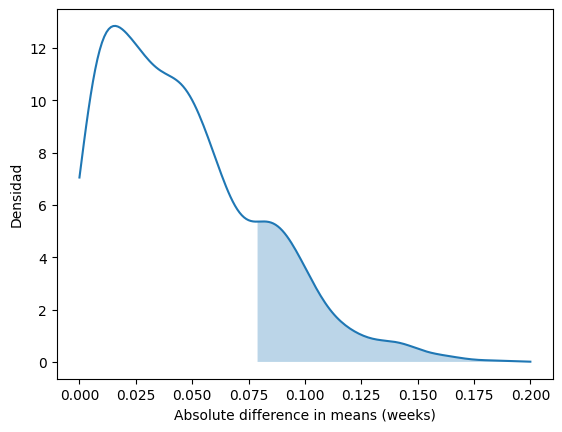

In [39]:
pmf = make_pmf(simulated_diffs, 0, 0.2)
pmf.plot()
fill_tail(pmf, observed_diff, "right")
plt.xlabel("Absolute difference in means (weeks)")
plt.ylabel("Densidad")

La siguiente función calcula el **p-value**, que es la fracción de valores simulados que son iguales o mayores que el valor observado.

In [40]:
def compute_p_value(simulated, observed):
    """Fracción de valores simulados iguales o mayores que el valor observado."""
    return (np.asarray(simulated) >= observed).mean().item()

In [41]:
compute_p_value(simulated_diffs, observed_diff)

0.19080919080919082

Alternativamente podemos calcularlo de la siguiente manera:

In [42]:
np.sum(np.asarray(simulated_diffs) >= 0.078).item()/len(simulated_diffs) * 100

19.08091908091908

En este ejemplo, el **p-value** es de aproximadamente el `18%`, lo que significa que es plausible que una diferencia tan grande como `0.078` semanas pueda ocurrir por casualidad. Ya que si **p-value** $> \alpha$, no rechazamos la $H_0$. Aqui, dependen del umbral $\alpha$ que consideremos.

En este ejemplo, la estadística de prueba es la diferencia absoluta entre las medias.

La **hipótesis nula** es que la distribución de la duración de los embarazos es en realidad la misma en ambos grupos. Y modelamos la **hipótesis nula** combinando los datos de ambos grupos en un solo conjunto, mezclando el conjunto y dividiéndolo en dos grupos del mismo tamaño que los originales. Este proceso se denomina **permutación**, que es otra palabra para mezclar.

Este enfoque computacional de la prueba de hipótesis facilita la combinación de estos elementos para probar diferentes estadísticas.

---
---
#Ejercicio #1

Probemos la comprobación de hipótesis con los datos sobre pingüinos de la leccion pasada.

Primero, leemos los datos y seleccionamos los **pinguinos chinstrap**.

In [43]:
url = "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins_raw.csv"

penguins = pd.read_csv(url).dropna(subset=["Body Mass (g)"])
chinstrap = penguins.query('Species.str.startswith("Chinstrap")')
chinstrap.shape

(68, 17)

Aqui extraemos los pesos (los transformamos a kilogramos) para machos y hembras por separado.

In [44]:
male = chinstrap.query("Sex == 'MALE'")
weights_male = male["Body Mass (g)"] / 1000

weights_male.mean().item()

3.9389705882352937

In [58]:
female = chinstrap.query("Sex == 'FEMALE'")
weights_female = female["Body Mass (g)"] / 1000

weights_female.mean().item()

3.5272058823529413

Utilice las funciones `abs_diff_means` y `simulate_groups` para generar un gran número de conjuntos de datos simulados bajo la **hipótesis nula** $H_0$ de que `los dos grupos tienen la misma distribución de pesos`, y calcule la **diferencia en las medias** de cada uno.

* Compare los resultados de la **simulación** con la **diferencia observada** y calcule el **p-value**.
* Grafique la distribución de las diferencias bajo la **hipótesis nula** $H_0$, utilize la funcion `make_pmf` y `plt.axvline` para marcar la posicion del valor observado, y calcule un **p-value** para la correlación observada. **¿Que puede concluir de tan solo ver esa grafica?**

**¿Es plausible que la diferencia aparente entre los grupos se deba al azar?**

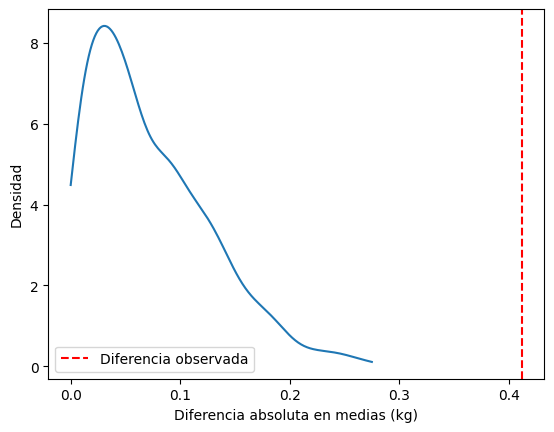

Diferencia observada: 0.412 kg
p-value: 0.0000


In [ ]:
# Preparamos los datos para el análisis
data = weights_male.values, weights_female.values

# Calculamos la diferencia observada entre las medias
observed_diff = abs_diff_means(data)

# Realizamos las simulaciones bajo la hipótesis nula
n_simulations = 10000
simulated_diffs = [abs_diff_means(simulate_groups(data)) for _ in range(n_simulations)]

# Calculamos el p-value
p_value = compute_p_value(simulated_diffs, observed_diff)

# Creamos la visualización
plt.figure(figsize=(10, 6))
pmf = make_pmf(simulated_diffs, 0, 1)
pmf.plot()
fill_tail(pmf, observed_diff, "right")
plt.axvline(x=observed_diff, color='red', linestyle='--', label='Diferencia observada')
plt.xlabel("Diferencia absoluta en medias (kg)")
plt.ylabel("Densidad")
plt.title("Distribución de diferencias bajo H₀")
plt.legend()
plt.show()

print(f"Diferencia observada entre medias: {observed_diff:.3f} kg")
print(f"p-value: {p_value:.4f}")
print("\nInterpretación:")
print("--------------------------------------")
if p_value < 0.05:
    print("Como el p-value es menor que 0.05, rechazamos la hipótesis nula.")
    print("Es poco probable que esta diferencia se deba al azar.")
else:
    print("Como el p-value es mayor que 0.05, no podemos rechazar la hipótesis nula.")
    print("La diferencia observada podría deberse al azar.")

In [46]:
# Tu codigo va aqui


In [47]:
def abs_diff_means(data):
    group1, group2 = data
    diff = np.mean(group1) - np.mean(group2)
    return np.abs(diff).item()

In [48]:
# Tu codigo va aqui

In [49]:
def simulate_groups(data):
    group1, group2 = data
    n, m = len(group1), len(group2)

    pool = np.hstack(data)
    np.random.shuffle(pool)
    return pool[:n], pool[-m:]

In [50]:
# Tu codigo va aqui

In [51]:
# Tu codigo va aqui

---
---
#Ejercicio #2

Utilizando los datos sobre pingüinos del ejercicio anterior, podemos extraer la profundidad y la longitud del culmen de las pingüinas (el culmen es la cresta superior del pico).

In [52]:
data = female["Culmen Depth (mm)"], female["Culmen Length (mm)"]

Podemos utilizar el mismo marco que hemos usado hasta ahorita para comprobar las **correlaciones**.

Por ejemplo, aqui, queremos averiguar si existe una correlación entre la profundidad y la logitud del pico de las pinguinas: **¿la proporcion de su longitud con su profundidad tiene una relacion?** o **¿podría este efecto deberse al azar?**

A continuacion mostramos un par de funciones que nos seran de utilidad:

* La siguiente función toma una tupla de `xs` e `ys` y calcula la magnitud de la correlación, positiva o negativa.

In [53]:
def abs_correlation(data):
    xs, ys = data
    corr = np.corrcoef(xs, ys)[0, 1]
    return np.abs(corr).item()

La correlacion entre estas variables es alrededor de `0.26`.

In [54]:
observed_corr = abs_correlation(data)
observed_corr

0.2563170802728449

La **hipótesis nula** $H_0$ es que **no existe correlación entre estas dimensiones del pico de las pinguinas**.

Al mezclar los **valores observados** (`observed_corr`), podemos simular un mundo en el que las distribuciones de la profundidad y longitud del pico son iguales, pero en el que las variables no están relacionadas.

* La siguiente función toma una tupla de `xs` e `ys`, mezcla las `xs` y devuelve una tupla que contiene las `xs` mezcladas y las `ys` originales. También funcionaría si mezcláramos las `ys`, o si mezcláramos ambas.

In [55]:
def permute(data):
    xs, ys = data
    new_xs = xs.values.copy()
    np.random.shuffle(new_xs)
    return new_xs, ys

Veamos si esta **correlación** podría darse por casualidad, aunque en realidad no exista ninguna correlación entre las mediciones.

Utilice la funcion `permute` para generar muchas permutaciones de estos datos y `abs_correlation` para calcular la correlación de cada una de ellas.

* Grafica la distribución de las correlaciones bajo la **hipótesis nula** $H_0$, utilize la funcion `make_pmf` y `plt.axvline` para marcar la posicion del valor observado, y calcule un **p-value** para la correlación observada.

**¿Cómo interpreta el resultado?**

In [56]:
# Tu codigo va aqui

In [57]:
# Tu codigo va aqui